# Tuning ML model quality for the "One-Click" online store

The "One-Click" online store sells various products: for children, for home, small household appliances, cosmetics, and even groceries. The store's report for the past period showed that customer activity has begun to decline. Attracting new customers is no longer as effective, as most of the target audience already knows about the store. A potential solution is to maintain the activity of existing customers. This can be achieved through personalized offers. Therefore, it is necessary to develop a solution that will allow for personalized offers to regular customers to increase their purchasing activity. A task solution plan has been prepared and approved by the company’s management:

1. It is necessary to label the level of financial activity of regular customers. The company distinguishes two levels of activity: "declined" if the customer started buying fewer products, and "previous level."
2. Next, it is necessary to collect data on customers in the following groups:  
	* Features describing the company’s employees' communication with the customer.
    * Features describing the customer's product behavior, e.g., which products are bought and how frequently.
    * Features describing the customer’s purchasing behavior, e.g., how much they spend in the store.
    * Features describing the customer’s behavior on the website, e.g., how many pages they view and how much time they spend on the site.
3. After data collection, it is necessary to build a model that predicts the probability of a decline in customer purchasing activity over the next three months.
4. The study should include additional financial department data on customer profitability, indicating the revenue each customer brought to the company over the past three months.
5. Using model data and customer profitability information, it is necessary to identify customer segments and develop personalized offers for them.

<a id='To-Content'></a>
**Project Contents**  
[Data Loading](#Data-Loading)\
[Data Preprocessing](#Data-Preprocessing)\
[Exploratory Data Analysis](#Exploratory-Data-Analysis)\
[Table Merging](#Table-Merging)\
[Correlation Analysis](#Correlation-Analysis)\
[Model Training with Pipelines](#Model-Training-with-Pipelines)\
[Feature Importance Analysis](#Feature-Importance-Analysis)\
[Customer Segmentation](#Customer-Segmentation)\
[Summary Conclusion](#Summary-Conclusion)

In [1]:
%%capture
!pip install shap
!pip install phik
!pip install --upgrade matplotlib seaborn scikit-learn scipy numpy pandas shap

In [2]:
# import libraries before the project start in one block

import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# loading class pipeline
from sklearn.pipeline import Pipeline

# loading classes for data preparation
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# loading class to work with missing values
from sklearn.impute import SimpleImputer

# loading function to work with metrics
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

# importing classes RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# loading required models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# tests to check correlations
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap



<a id="Data-Loading"></a>
## Data Loading
[Back to Content](#back-to-content)

In [3]:
# setting standard dataframe format before loading
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.options.mode.chained_assignment = None # suppress warnings on column access in dataframe

try:
    pd.set_option('future.no_silent_downcasting', True)
except:
    pass

# import data
try:
    market_file = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_7_V_odin_klik/market_file.csv')
    market_money = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_7_V_odin_klik/market_money.csv') 
    market_time = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_7_V_odin_klik/market_time.csv')
    money = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_7_V_odin_klik/money.csv', sep=';',decimal=',')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';',decimal=',')


# displaying information about structure and data for each dataframe 
def get_info(dataset):
    display(dataset.info(), dataset.head(5), dataset.tail(5))

        
get_info(market_file)
get_info(market_money)
get_info(market_time)
get_info(money);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1295,216643,Прежний уровень,стандарт,да,6.600,3,318,0.240,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.100,4,454,0.210,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.100,3,586,0.200,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.300,5,645,0.120,Техника для красоты и здоровья,3,3,5,7
1299,216647,Прежний уровень,премиум,да,4.000,5,906,0.940,Техника для красоты и здоровья,4,5,3,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.000
1,215348,текущий_месяц,3293.100
2,215348,предыдущий_месяц,0.000
3,215349,препредыдущий_месяц,4472.000
4,215349,текущий_месяц,4971.600


,id,Период,Выручка
3895,216646,препредыдущий_месяц,4725.000
3896,216646,предыдущий_месяц,4923.000
3897,216647,предыдущий_месяц,4720.000
3898,216647,препредыдущий_месяц,5183.000
3899,216647,текущий_месяц,4448.300


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Период,минут
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10
2599,216647,предыдцщий_месяц,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
0,215348,0.980
1,215349,4.160
2,215350,3.130
3,215351,4.870
4,215352,4.210


,id,Прибыль
1295,216643,4.440
1296,216644,6.110
1297,216645,3.290
1298,216646,4.030
1299,216647,3.280


**Conclusion**

Upon initial evaluation of loaded data, becomes apparent the need for:
(1) column and text parameter renaming (for duplicate check)
(2) type correction to suitable types for easy analysis
(3) checking original data for missing values and duplicates for subsequent removal. 

<a id="Data-Preprocessing"></a>
## Data Preprocessing
[Back to Content](#back-to-content)

We will address and correct (if necessary) each of the noted remarks from the previous section in order, as follows:

In [4]:
# converting main dataframe column names to lower case and removing spaces
market_file.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i.replace(' ', '_')).lower() for i in market_file.columns]

# correcting column names in remaining dataframes with direct commands
correct_columns = {
    'Период': 'период',
    'Выручка': 'выручка',
    'Прибыль': 'прибыль'
}

market_money = market_money.rename(columns=correct_columns)
market_time = market_time.rename(columns=correct_columns)
money = money.rename(columns=correct_columns)

# checking column names after name change
display(market_file.columns,
       market_money.columns,
       market_time.columns,
       money.columns)


Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Index(['id', 'период', 'выручка'], dtype='object')

Index(['id', 'период', 'минут'], dtype='object')

Index(['id', 'прибыль'], dtype='object')

In [5]:
# checking unique values in text columns of dataframe market_file
columns_str = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать','популярная_категория']

display(market_file.shape)

for column in columns_str:
    display(market_file[column].unique())

# and in other dataframes
display(market_money['период'].unique())
display(market_time['период'].unique())

(1300, 13)

array(['Снизилась', 'Прежний уровень'], dtype=object)

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

array(['да', 'нет'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [6]:
# converting all text values to lowercase in three datasets
market_file = market_file.apply(lambda col: col.apply(lambda x: x.lower() if isinstance(x, str) else x))
market_money = market_money.apply(lambda col: col.apply(lambda x: x.lower() if isinstance(x, str) else x))
market_time = market_time.apply(lambda col: col.apply(lambda x: x.lower() if isinstance(x, str) else x))

# converting spaces on '_'
def replace_spaces(s):
    return s.replace(" ", "_")

columns_str = ['покупательская_активность','популярная_категория']

for column in columns_str:
    market_file[column] = market_file[column].apply(replace_spaces)

display(market_file.head(2), market_money.head(2), market_time.head(2), money.head(2))

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.400,5,121,0.000,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.400,4,819,0.750,товары_для_детей,4,4,2,5


,id,период,выручка
0,215348,препредыдущий_месяц,0.000
1,215348,текущий_месяц,3293.100


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


,id,прибыль
0,215348,0.980
1,215349,4.160


In [7]:
# replacing typos and implicit duplicates in text column values
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['популярная_категория'] = market_file['популярная_категория'].replace('Косметика_и_аксесуары', 'Косметика_и_аксессуары')

market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


In [8]:
# correcting data types to `int32` and `float32`
market_file[['маркет_актив_6_мес','акционные_покупки']] = market_file[['маркет_актив_6_мес','акционные_покупки']].astype(np.float32)
market_file[['id','маркет_актив_тек_мес','длительность','средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит']] = \
market_file[['id','маркет_актив_тек_мес','длительность','средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит']].astype(np.int32)


market_money['id'] = market_money['id'].astype(np.int32)
market_money['выручка'] = market_money['выручка'].astype(np.float32)

market_time[['id','минут']] = market_time[['id','минут']].astype(np.int32)

money['id'] = money['id'].astype(np.int32)
money['прибыль'] = money['прибыль'].astype(np.float32)


In [9]:
# verifying values after data type conversions
columns_str = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать','популярная_категория']

for column in columns_str:
    print(market_file[column].unique())

# and in other dataframes
print(market_money['период'].unique())
print(market_time['период'].unique(),'\n')

market_file.info() 
market_money.info()
market_time.info() 
money.info()

['снизилась' 'прежний_уровень']
['премиум' 'стандарт']
['да' 'нет']
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдущий_месяц'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int32  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float32
 5   маркет_актив_тек_мес                 1300 non-null   int32  
 6   длительность                         

In [10]:
# verifying dataframe for missing values and potential duplicates
print(f'Количество пропусков по таблицу market_file: {market_file.isna().sum()}')
print(f'Количество пропусков по таблицу market_money: {market_money.isna().sum()}')
print(f'Количество пропусков по таблицу market_time: {market_time.isna().sum()}')
print(f'Количество пропусков по таблицу money: {money.isna().sum()}')

# removing duplicates
print('\nДубликаты по каждой из таблиц:')
display(market_file.duplicated().sum())
display(market_money.duplicated().sum())
display(market_time.duplicated().sum())
display(money.duplicated().sum())


Количество пропусков по таблицу market_file: id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64
Количество пропусков по таблицу market_money: id         0
период     0
выручка    0
dtype: int64
Количество пропусков по таблицу market_time: id        0
период    0
минут     0
dtype: int64
Количество пропусков по таблицу money: id         0
прибыль    0
dtype: int64

Дубликаты по каждой из таблиц:


0

0

0

0

**Conclusion**

As a result of data preprocessing, the following adjustments were made:

- column names in all tables were converted to lowercase and spaces replaced with underscores;
- in text data across tables, spaces were replaced with underscores, implicit duplicates and typos were identified and replaced, and data was also converted to lowercase;
- numeric data was converted to int32 and float32 types as necessary;
- checks did not reveal any missing values or duplicates in the tables.

Some parameters in the tables are binary, such as "разрешить_сообщать" and "тип_сервиса", for clarity and research analysis purposes these data will be left in their current form. In the further stage of preparing data for modeling, these features can be encoded with binary categories "1" and "0".

In [11]:
for column in market_money.columns:
    display(market_money[column].unique())


#display(market_money.duplicated().sum())
#display(market_time.duplicated().sum())
#display(money.duplicated().sum())

array([215348, 215349, 215350, ..., 216645, 216646, 216647], dtype=int32)

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

array([   0. , 3293.1, 4472. , ..., 5224.6, 4720. , 4448.3], dtype=float32)

<a id="Exploratory-Data-Analysis"></a>
## Exploratory Data Analysis
[Back to Content](#back-to-content)

Let's start by examining the standard statistics for each table and exploring the distributions of the data.

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000
mean,215997.500,4.254,4.012,601.898,0.320,3.270,2.840,4.185,8.177
std,375.422,1.015,0.697,249.856,0.250,1.355,1.971,1.955,3.978
min,215348.000,0.900,3.000,110.000,0.000,1.000,0.000,0.000,1.000
25%,215672.750,3.700,4.000,405.500,0.170,2.000,1.000,3.000,5.000
50%,215997.500,4.200,4.000,606.000,0.240,3.000,3.000,4.000,8.000
75%,216322.250,4.900,4.000,806.000,0.300,4.000,4.000,6.000,11.000
max,216647.000,6.600,5.000,1079.000,0.990,6.000,10.000,9.000,20.000


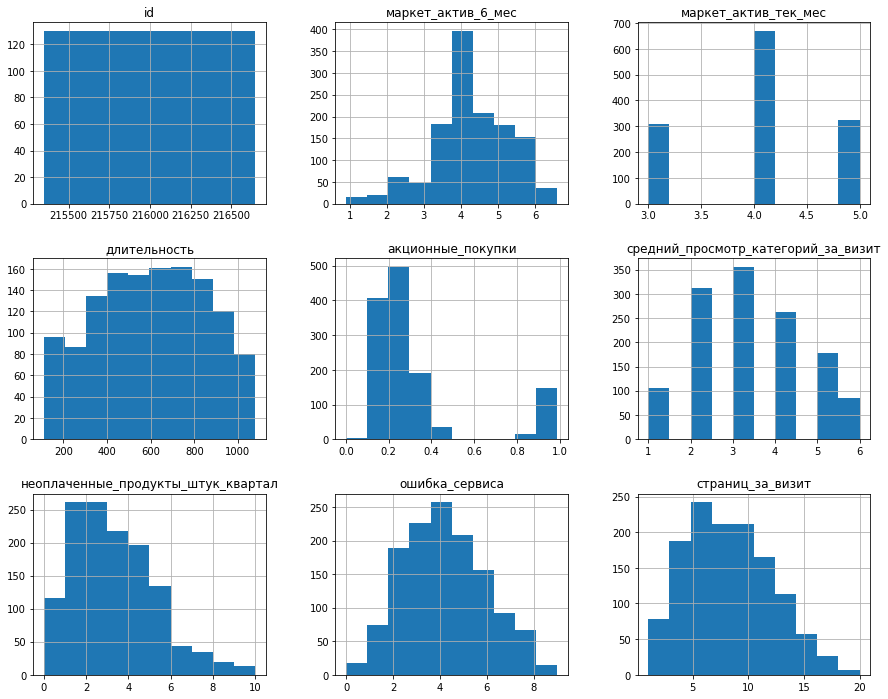

In [12]:
# will see distribution of data in dataframe `market_file`
market_file.hist(figsize=(15, 12));
display(market_file.describe())

In the table **market_file**, the numerical data is distributed both close to "normal" (features **маркет_актив_тек_мес**, **средний_просмотр_категорий_за_визит**, **ошибка_сервиса**) and rather "non-normal" (features **маркет_актив_6_мес**, **длительность**, **акционные покупки**, **неоплаченные_продукты_штук_квартал**, **страниц_за_визит**). The feature **маркет_актив_тек_мес** appears more like a categorical feature, as it has only three value options.  
There are no outliers or anomalous values observed; let's examine them separately, along with the categorical features.

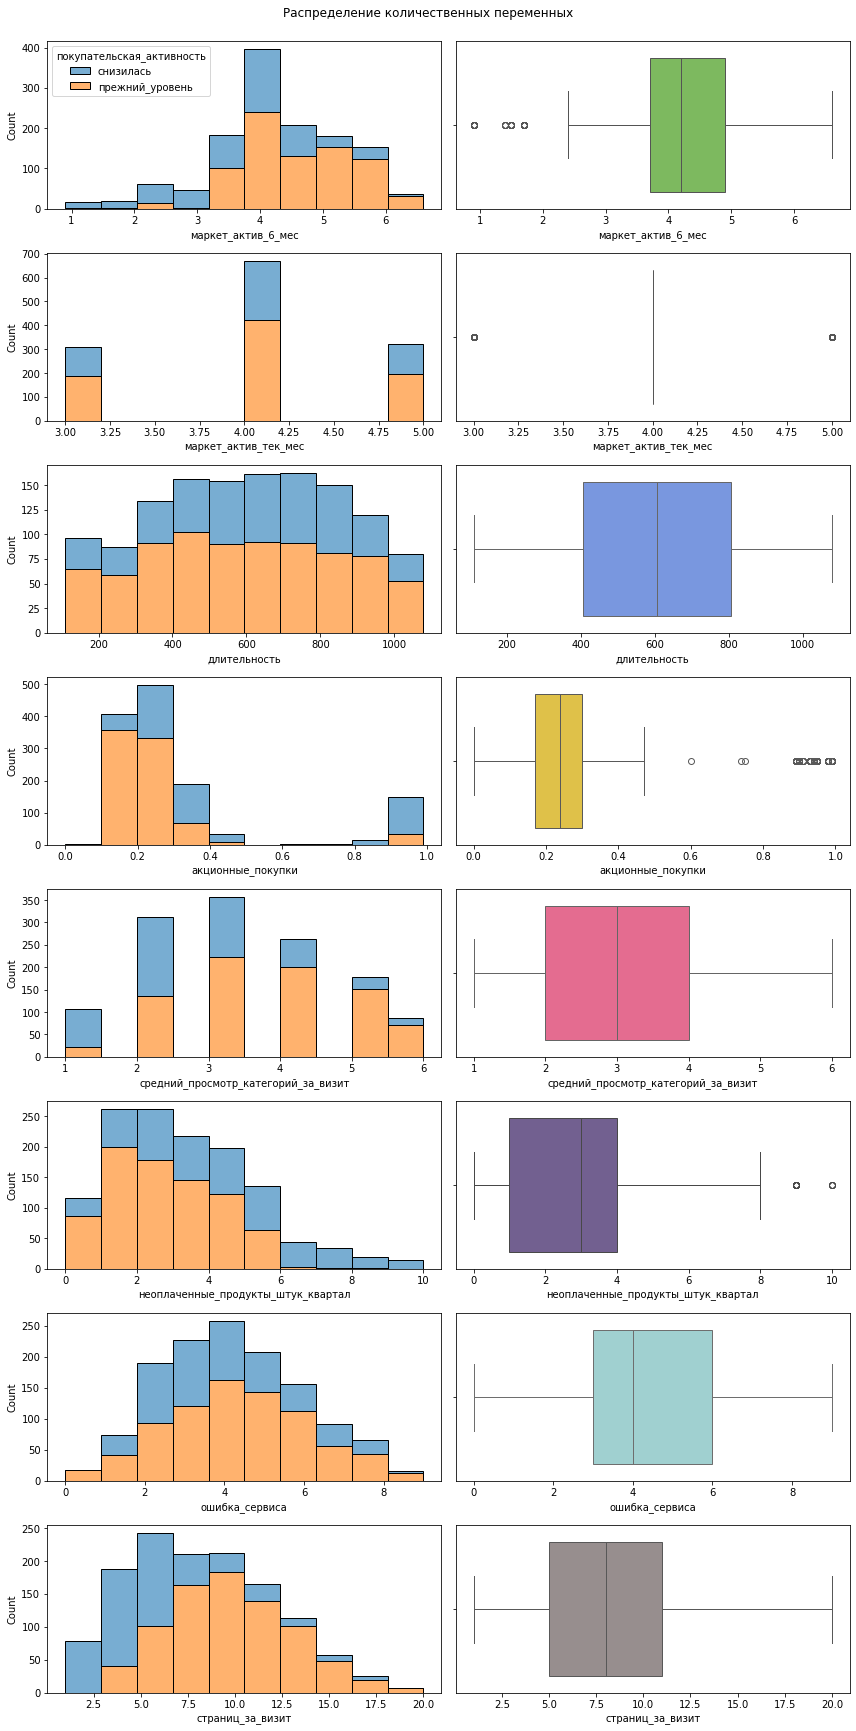

In [ ]:
# let's separately plot histograms and box plots for the quantitative features

colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8','#988D8D']

columns_num = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'длительность',
               'акционные_покупки',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит']

fig, axes = plt.subplots(8, 2, figsize=(12, 24));
fig.suptitle('Distribution of quantitative variables', y=1)


for index, column in enumerate(columns_num):  
    
    ax = axes[index][0]
    sns.histplot(data=market_file,x=column, bins=10, 
                 color=colors[index],
                 hue='покупательская_активность', 
                 multiple='stack', alpha=0.6,
                 legend='auto' if index == 0 else False,ax=ax)
    
    ax = axes[index][1]
    sns.boxplot(x=market_file[column], color=colors[index],ax=ax)
    ax.set_ylabel('')

plt.tight_layout();
plt.show();

No critical anomalies that would need to be removed were identified; however, the existing outliers in the features **маркет_актив_6_мес** and **акционные_покупки** are more likely to represent distinct customer groups, whose data will be important for model training. The feature **маркет_актив_тек_мес** indeed appears to be categorical.

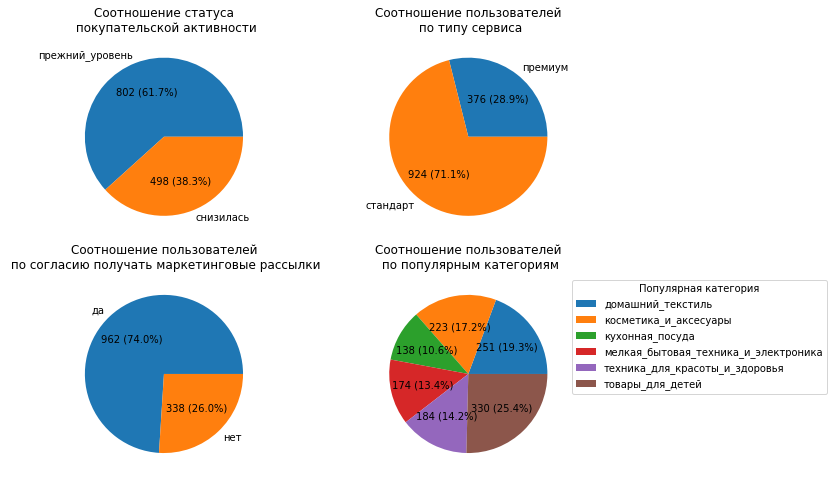

In [ ]:
# let's plot pie charts for the categorical data

# function for calculating absolute values to display on the chart
def absolute_value(val,df):
    a = round(val/100.*df.sum())
    return a

plt.figure(figsize=[10, 8])

plt.subplot(2,2,1)
market_file_grouped = market_file.groupby('покупательская_активность')['покупательская_активность'].count()
market_file.groupby('покупательская_активность')['покупательская_активность'].count().plot(kind='pie', 
             title ='Ratio of purchasing\n activity status',
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, market_file_grouped)} ({x:.1f}%)');

plt.subplot(2,2,2)
market_file_grouped = market_file.groupby('тип_сервиса')['тип_сервиса'].count()
market_file.groupby('тип_сервиса')['тип_сервиса'].count().plot(kind='pie', 
             title ="Ratio of users by\n service type",
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, market_file_grouped)} ({x:.1f}%)');


plt.subplot(2,2,3)
market_file_grouped = market_file.groupby('разрешить_сообщать')['разрешить_сообщать'].count()
market_file.groupby('разрешить_сообщать')['разрешить_сообщать'].count().plot(kind='pie', 
             title ="Ratio of users agreeing\n to receive marketing newsletters",
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, market_file_grouped)} ({x:.1f}%)');

plt.subplot(2,2,4)
market_file_grouped = market_file.groupby('популярная_категория')['популярная_категория'].count()
market_file.groupby('популярная_категория')['популярная_категория'].count().plot(kind='pie', 
             title ="Ratio of users\n by popular categories",
             radius=1,
             ylabel='',
             labels=None,
             autopct=lambda x: f'{absolute_value(x, market_file_grouped)} ({x:.1f}%)');
#plt.legend(title='Платформы', bbox_to_anchor=(1, 1),ncol=2)
plt.legend(market_file_grouped.index,title="Популярная категория", bbox_to_anchor=(1, 1));

,id,выручка
count,3900.000,3900.000
mean,215997.500,5025.696
std,375.326,1777.704
min,215348.000,0.000
25%,215672.750,4590.150
50%,215997.500,4957.500
75%,216322.250,5363.000
max,216647.000,106862.203


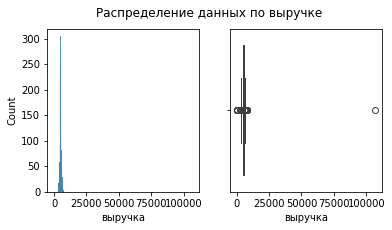

In [ ]:
# let's examine the data distribution in the table market_money
plt.figure(figsize=(6, 3))
plt.suptitle('Distribution of data by revenue')
plt.subplot(1, 2, 1)
sns.histplot(market_money['выручка'])

plt.subplot(1, 2, 2)
sns.boxplot(x=market_money['выручка'])

display(market_money.describe())


In [ ]:
# find the anomalous values
market_money[market_money['выручка'] > 10000]


,id,период,выручка
98,215380,текущий_месяц,106862.203


In [ ]:
# replace the single anomalous value with the mean
market_money.loc[98,'выручка'] = market_money['выручка'].mean()

market_money.loc[98,'выручка']

5025.6963

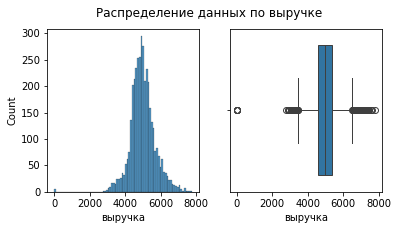

In [ ]:
# plot distribution again
plt.figure(figsize=(6, 3))
plt.suptitle('Distribution of data by revenue')

plt.subplot(1, 2, 1)
sns.histplot(market_money['выручка'])

plt.subplot(1, 2, 2)
sns.boxplot(x=market_money['выручка']);


In [19]:
market_money[market_money['выручка'] < 1000]


,id,период,выручка
0,215348,препредыдущий_месяц,0.000
2,215348,предыдущий_месяц,0.000
28,215357,препредыдущий_месяц,0.000
29,215357,предыдущий_месяц,0.000
34,215359,предыдущий_месяц,0.000
35,215359,препредыдущий_месяц,0.000


The revenue data is distributed close to normal, and a critical anomaly in one of the values has been replaced with the mean. Additionally, three customers have been identified who made purchases only in the current month (with zero revenue in the previous two months); we will exclude these customers, as their lack of historical revenue data makes them less relevant for model training:

In [ ]:
# remove from all tables the rows corresponding to customers with zero revenue
market_file = market_file.query("id not in [215348,215357,215359]")
market_money = market_money.query("id not in [215348,215357,215359]")
market_time = market_time.query("id not in [215348,215357,215359]")
money = money.query("id not in [215348,215357,215359]")

# check the number of remaining records in each table
market_file.info()
market_money.info()
market_time.info()
money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int32  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float32
 5   маркет_актив_тек_мес                 1297 non-null   int32  
 6   длительность                         1297 non-null   int32  
 7   акционные_покупки                    1297 non-null   float32
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int32  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int32  
 11  ошибка_сервиса                     

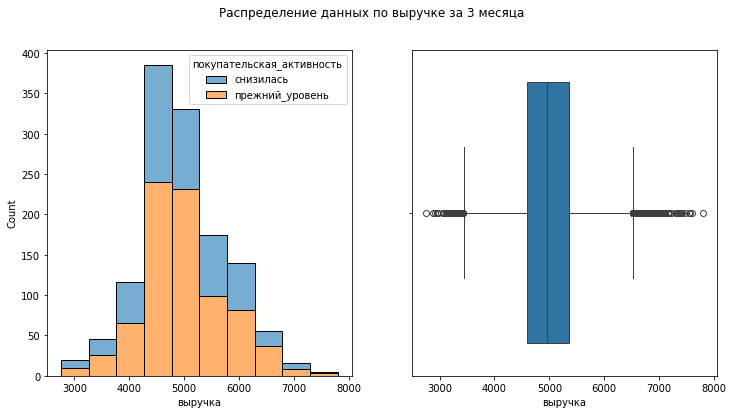

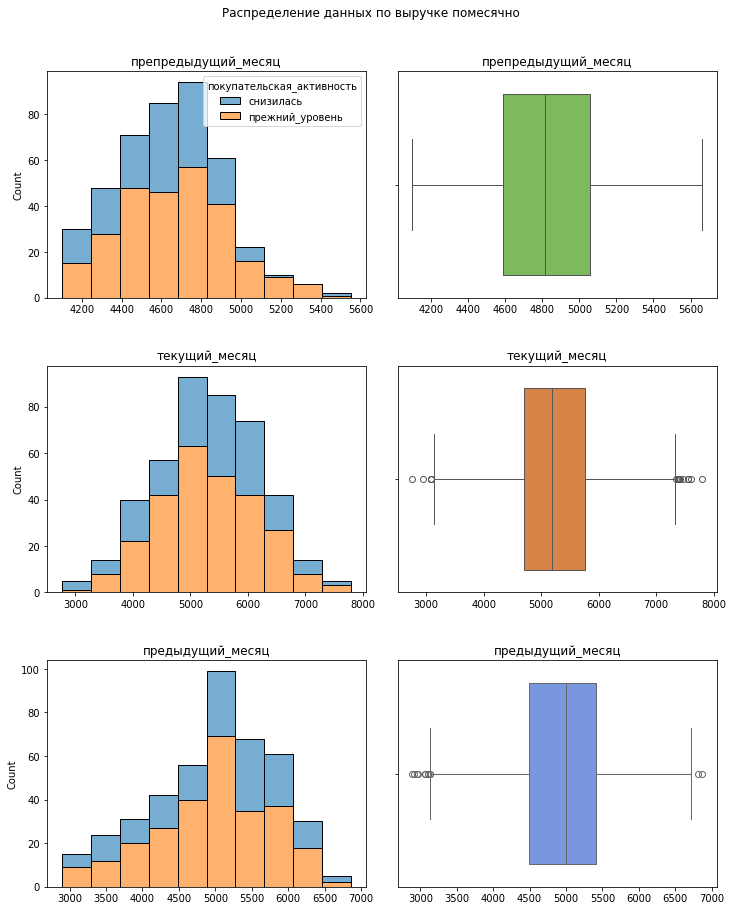

In [ ]:
# check the final distribution of data by revenue, considering the target variable
plt.figure(figsize=(12, 6))
plt.suptitle('Distribution of data by revenue over 3 months')

plt.subplot(1, 2, 1)
sns.histplot(data=market_money,x=market_money['выручка'],bins=10,
             hue=market_file['покупательская_активность'], multiple='stack', alpha=0.6)

plt.subplot(1, 2, 2)
sns.boxplot(x=market_money['выручка']);


# and check monthly
plt.figure(figsize=(12, 15))
plt.suptitle('Monthly distribution of data by revenue',y=0.94)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
colors = ['#78C850', '#F08030', '#6890F0']

for index,month in enumerate(market_money['период'].unique()):
    plt.subplot(3, 2, index*2+1)
    plt.title(month)
    
    # extract the id split by the target variable for hue labeling
    filtered_market_money = market_money[market_money['период'] == month]
    filtered_ids = filtered_market_money['id']
    # filter market_file by the values in the id column that are present in filtered_ids
    result = market_file[market_file['id'].isin(filtered_ids)]
    
    sns.histplot(data=market_money,x=market_money[market_money['период']==month]['выручка'],
                 bins=10, hue=result['покупательская_активность'], multiple='stack', alpha=0.6,
                 color=colors[index],legend='auto' if index == 0 else False)
    plt.xlabel('')

    plt.subplot(3, 2, index*2+2)
    plt.title(month)
    sns.boxplot(x=market_money[market_money['период']==month]['выручка'],color=colors[index])
    plt.xlabel('');

# now it's beautiful!

In [ ]:
# examine the statistics for the table with data on the time spent on the site
market_time.describe()

,id,минут
count,2594.000,2594.000
mean,215998.987,13.340
std,374.506,4.082
min,215349.000,4.000
25%,215675.000,10.000
50%,215999.000,13.000
75%,216323.000,16.000
max,216647.000,23.000


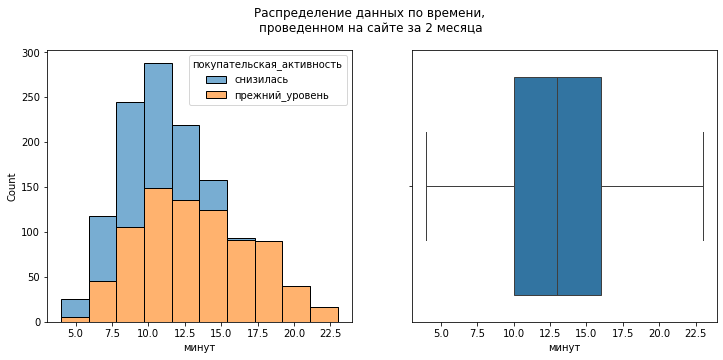

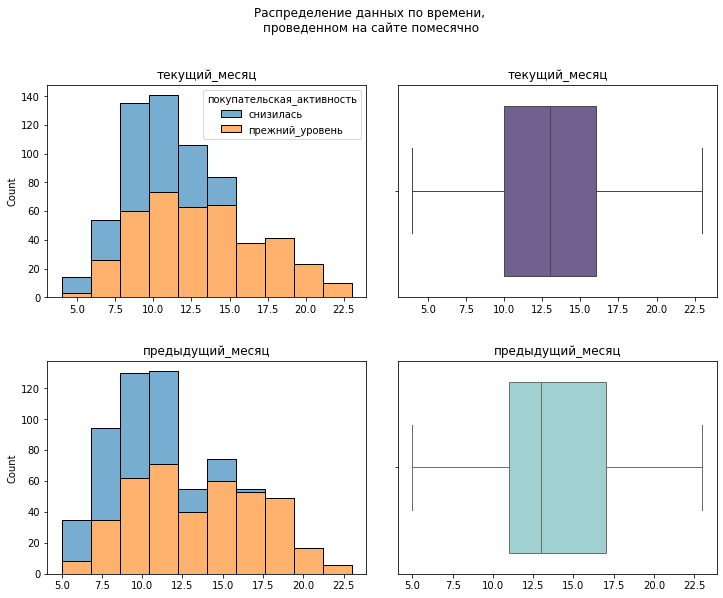

In [ ]:
# plot the distributions of the time spent on the site over 2 months, considering the target variable

plt.figure(figsize=(12, 5))
plt.suptitle('Distribution of data by time spent\n on the site over 2 months',y=1)

plt.subplot(1, 2, 1)
sns.histplot(data=market_time,x=market_time['минут'],bins=10,
             hue=market_file['покупательская_активность'], multiple='stack', alpha=0.6)

plt.subplot(1, 2, 2)
sns.boxplot(x=market_time['минут']);

# and check monthly
plt.figure(figsize=(12, 9))
plt.suptitle('Monthly distribution of data\n by time spent on the site',y=1)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
colors = ['#705898', '#98D8D8']

for index,month in enumerate(market_time['период'].unique()):
    plt.subplot(2, 2, index*2+1)
    plt.title(month)
    
    # extract the id split by the target variable for hue labeling
    filtered_market_time = market_time[market_time['период'] == month]
    filtered_ids = filtered_market_time['id']
    # filter market_file by the values in the id column that are present in filtered_ids
    result = market_file[market_file['id'].isin(filtered_ids)]
    
    sns.histplot(data=market_time, x=market_time[market_time['период']==month]['минут'],bins=10, 
                 hue=result['покупательская_активность'], multiple='stack', alpha=0.6,
                 color=colors[index],legend='auto' if index == 0 else False)
    
    plt.xlabel('')

    plt.subplot(2, 2, index*2+2)
    plt.title(month)
    sns.boxplot(x=market_time[market_time['период']==month]['минут'],color=colors[index])
    plt.xlabel('');

In [ ]:
# examine the statistics for the table with data on average monthly profit from users
money.describe()

,id,прибыль
count,1297.000,1297.000
mean,215998.987,3.998
std,374.579,1.011
min,215349.000,0.860
25%,215675.000,3.300
50%,215999.000,4.040
75%,216323.000,4.670
max,216647.000,7.430


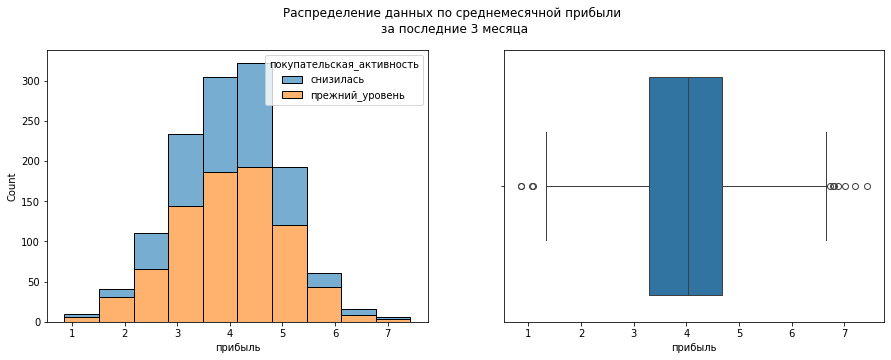

In [ ]:
# plot the distribution of data by profitability, considering the target variable
plt.figure(figsize=(15, 5))
plt.suptitle('Distribution of data by average monthly\n profit over the last 3 months',y=1)

plt.subplot(1, 2, 1)
sns.histplot(data=money,x=money['прибыль'],bins=10,
             hue=market_file['покупательская_активность'], multiple='stack', alpha=0.6)

plt.subplot(1, 2, 2)
sns.boxplot(x=money['прибыль']);


**Conclusion**

In the table with user and purchase data (**market_file**), we observe that the quantitative data is not all distributed close to a "normal distribution," which will need to be considered when evaluating correlation. No anomalies were identified in this data, and the outliers are within acceptable limits. The binary categorical features are also unevenly distributed—class balancing may be necessary during data preparation for model training. The data for the multi-class feature "popular categories" is distributed more evenly.

In the table with revenue data over the last 3 months (**market_money**), the only anomaly with a very high purchase amount was replaced with the mean value from the entire table. Additionally, data for three users who did not make purchases in previous months were excluded from all tables. The corrected revenue data (both overall for 3 months and monthly) is distributed close to normal, with insignificant outliers.

In the table with data on time spent on the site (**market_time**), no anomalies or outliers were identified. The distribution of data over 2 months and the current month is close to normal, while the previous month's data shows an average value with a dip (indicated by two roughly equal peaks on the histogram, just below and above the average).

In the table with average monthly profit data over the last 3 months (**money**), no anomalies or critical outliers were identified, and the data is distributed close to "normal."

<a id='Merging-Tables'></a>
## Merging Tables
[Back to content](#Back-to-content)

In [ ]:
# transform the tables with revenue and profit data into a monthly breakdown for easier merging and analysis
pivot_table_money = market_money.pivot_table(index='id',columns='период',aggfunc='sum')
pivot_table_money.columns = pivot_table_money.columns.map('_'.join)
pivot_table_money = pivot_table_money.reset_index()

pivot_table_time = market_time.pivot_table(index='id',columns='период',aggfunc='sum')
pivot_table_time.columns = pivot_table_time.columns.map('_'.join)
pivot_table_time = pivot_table_time.reset_index()

display(pivot_table_money.head())
display(pivot_table_time.head())

display(pivot_table_money.shape)
display(pivot_table_time.shape)


,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.000,4472.000,4971.600
1,215350,5457.500,4826.000,5058.400
2,215351,6158.000,4793.000,6610.400
3,215352,5807.500,4594.000,5872.500
4,215353,4738.500,5124.000,5388.500


,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


(1297, 4)

(1297, 3)

In [ ]:
# record the dimensions of the original table before merging
display(market_file.shape)

# sequentially join the derived tables to the main DataFrame market_file based on the id column
market_file = market_file.merge(pivot_table_money,on='id',how='left')
market_file = market_file.merge(pivot_table_time,on='id',how='left')

# check the dimensions, ensure there are no NaN values, and display the first few rows for visibility
display(market_file.shape)

print('Number of missing values in market_file after merging the tables:\n',market_file.isna().sum())

market_file.head(5)

(1297, 13)

(1297, 18)

Количество пропусков в market_file после объединения таблиц:
 id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,снизилась,премиум,да,4.400,4,819,0.750,товары_для_детей,4,4,2,5,5216.000,4472.000,4971.600,12,10
1,215350,снизилась,стандарт,нет,4.900,3,539,0.140,домашний_текстиль,5,2,1,5,5457.500,4826.000,5058.400,8,13
2,215351,снизилась,стандарт,да,3.200,5,896,0.990,товары_для_детей,5,0,6,4,6158.000,4793.000,6610.400,11,13
3,215352,снизилась,стандарт,нет,5.100,3,1064,0.940,товары_для_детей,3,2,3,2,5807.500,4594.000,5872.500,8,11
4,215353,снизилась,стандарт,да,3.300,4,762,0.260,домашний_текстиль,4,1,1,4,4738.500,5124.000,5388.500,10,10


**Conclusion**

In the process of preparing the data for model training and correlation analysis, we merged the three available datasets—**market_file**, **market_money**, and **market_time**—into a single table, after converting the data in the last two datasets into a monthly format for each user.

<a id='Correlation-Analysis'></a>
## Correlation Analysis
[Back to content](#Back-to-content)

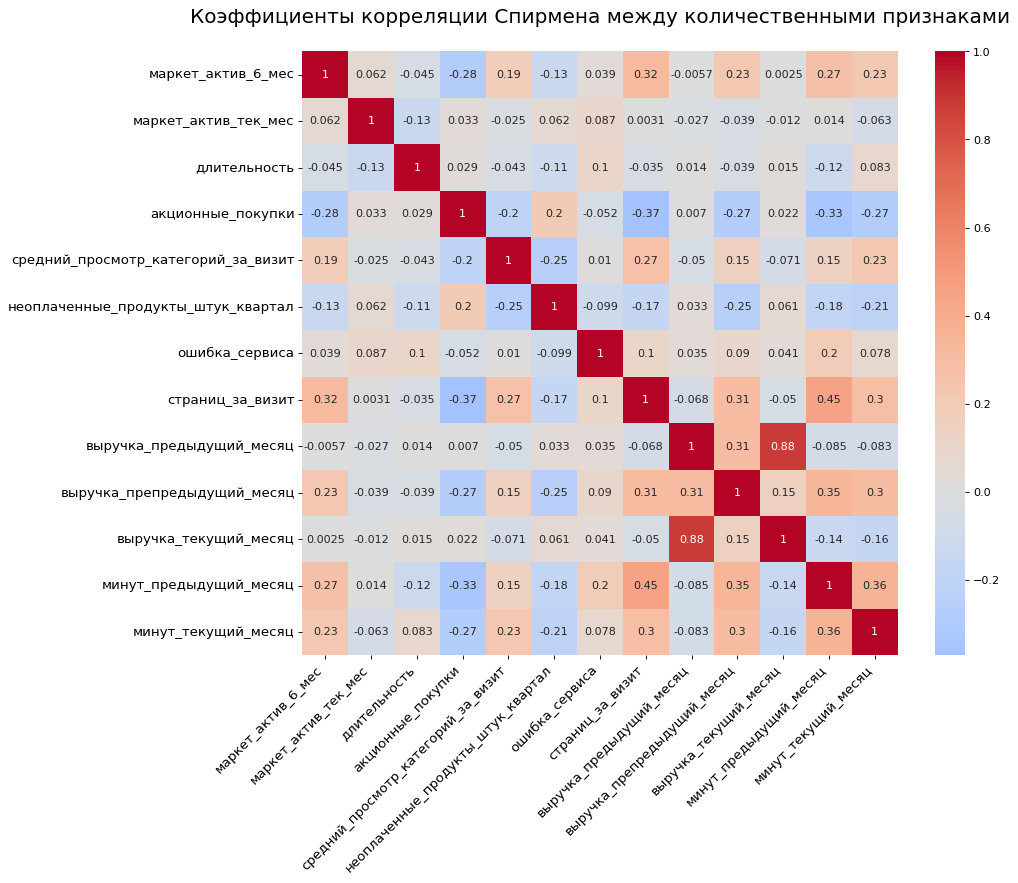

In [ ]:
# check the relationships between the quantitative features

# since most of our data is not normally distributed, we will use Spearman's correlation coefficient
# the matrix is quite large, so it's better to view it as a heatmap
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(market_file[['маркет_актив_6_мес',
                     'маркет_актив_тек_мес',
                     'длительность',
                     'акционные_покупки',
                     'средний_просмотр_категорий_за_визит',
                     'неоплаченные_продукты_штук_квартал',
                     'ошибка_сервиса',
                     'страниц_за_визит',
                     'выручка_предыдущий_месяц',
                     'выручка_препредыдущий_месяц',
                     'выручка_текущий_месяц',
                     'минут_предыдущий_месяц',
                     'минут_текущий_месяц']].corr(method='spearman'), 
            xticklabels=market_file[['маркет_актив_6_мес',
                     'маркет_актив_тек_мес',
                     'длительность',
                     'акционные_покупки',
                     'средний_просмотр_категорий_за_визит',
                     'неоплаченные_продукты_штук_квартал',
                     'ошибка_сервиса',
                     'страниц_за_визит',
                     'выручка_предыдущий_месяц',
                     'выручка_препредыдущий_месяц',
                     'выручка_текущий_месяц',
                     'минут_предыдущий_месяц',
                     'минут_текущий_месяц']].corr(method='spearman').columns, 
            yticklabels=market_file[['маркет_актив_6_мес',
                     'маркет_актив_тек_мес',
                     'длительность',
                     'акционные_покупки',
                     'средний_просмотр_категорий_за_визит',
                     'неоплаченные_продукты_штук_квартал',
                     'ошибка_сервиса',
                     'страниц_за_визит',
                     'выручка_предыдущий_месяц',
                     'выручка_препредыдущий_месяц',
                     'выручка_текущий_месяц',
                     'минут_предыдущий_месяц',
                     'минут_текущий_месяц']].corr(method='spearman').columns, 
            cmap='coolwarm' , 
            center=0, 
            annot=True)

plt.title('Spearmans correlation coefficients between quantitative features\n', fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()


In [ ]:
# checking for multicollinearity using VIF (Variance Inflation Factor)
market_file_VIF = market_file.loc[:,['маркет_актив_6_мес',
                     'маркет_актив_тек_мес',
                     'длительность',
                     'акционные_покупки',
                     'средний_просмотр_категорий_за_визит',
                     'неоплаченные_продукты_штук_квартал',
                     'ошибка_сервиса',
                     'страниц_за_визит',
                     'выручка_предыдущий_месяц',
                     'выручка_препредыдущий_месяц',
                     'выручка_текущий_месяц',
                     'минут_предыдущий_месяц',
                     'минут_текущий_месяц']]

# adding a constant column for VIF calculation
market_file_VIF.loc[:, 'Intercept'] = 1

# calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = market_file_VIF.columns
vif_data['VIF'] = [variance_inflation_factor(market_file_VIF.values, i) for i in range(market_file_VIF.shape[1])]

display(vif_data)

,feature,VIF
0,маркет_актив_6_мес,1.222
1,маркет_актив_тек_мес,1.044
2,длительность,1.099
3,акционные_покупки,1.186
4,средний_просмотр_категорий_за_визит,1.179
5,неоплаченные_продукты_штук_квартал,1.198
6,ошибка_сервиса,1.079
7,страниц_за_визит,1.417
8,выручка_предыдущий_месяц,4.239
9,выручка_препредыдущий_месяц,1.612


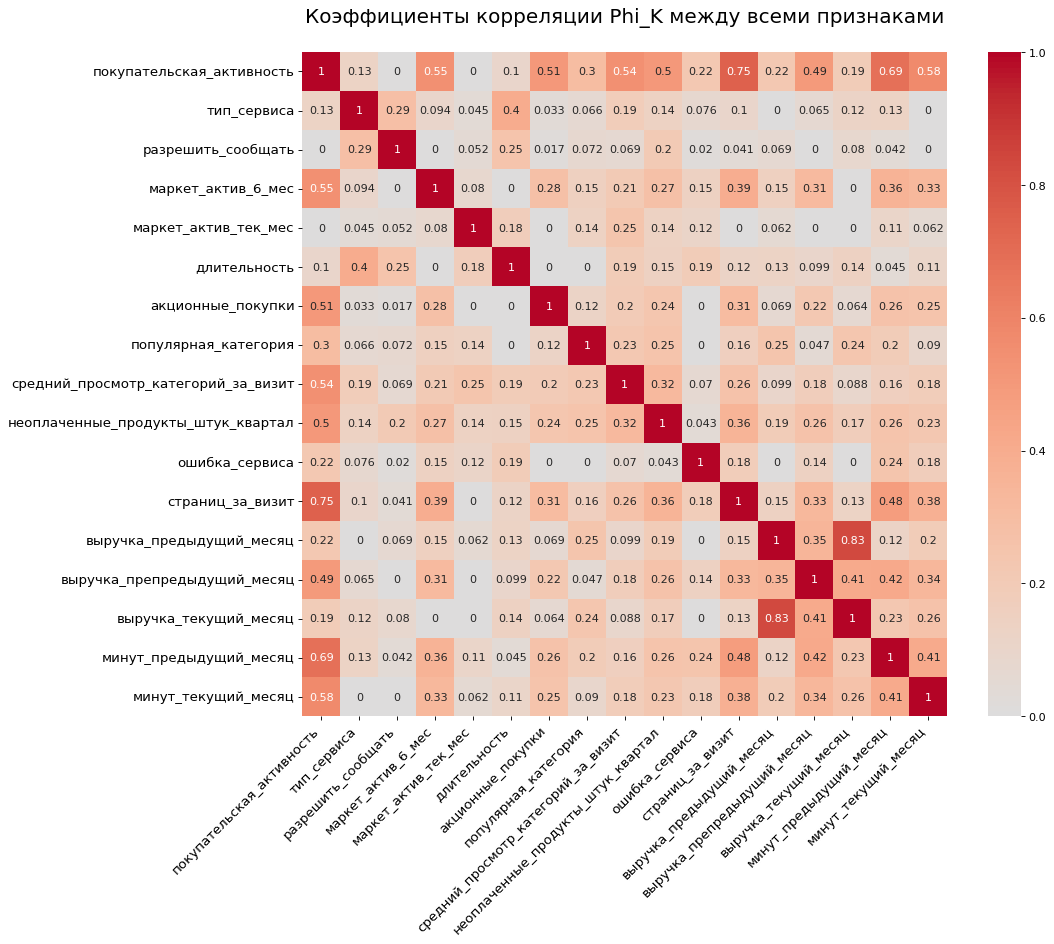

In [ ]:
# calculating the correlation matrix using the Phi-K coefficient
# plot three matrices: for all data and split by the target variable "purchase activity"

# calculation of the correlation matrix using the Phi-K coefficient for all data
mf = market_file.drop('id', axis=1)

phik_matrix = mf.phik_matrix(interval_cols=['маркет_актив_6_мес',
                     'маркет_актив_тек_мес',
                     'длительность',
                     'акционные_покупки',
                     'средний_просмотр_категорий_за_визит',
                     'неоплаченные_продукты_штук_квартал',
                     'ошибка_сервиса',
                     'страниц_за_визит',
                     'выручка_предыдущий_месяц',
                     'выручка_препредыдущий_месяц',
                     'выручка_текущий_месяц',
                     'минут_предыдущий_месяц',
                     'минут_текущий_месяц'])

# the matrix is quite large, so it's better to view it as a heatmap
plt.figure(figsize=(13,11), dpi= 80)
sns.heatmap(phik_matrix.values, xticklabels=phik_matrix.columns, yticklabels=phik_matrix.index, cmap='coolwarm', center=0, annot=True)

plt.title('Phi-K correlation coefficients between all features\n', fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

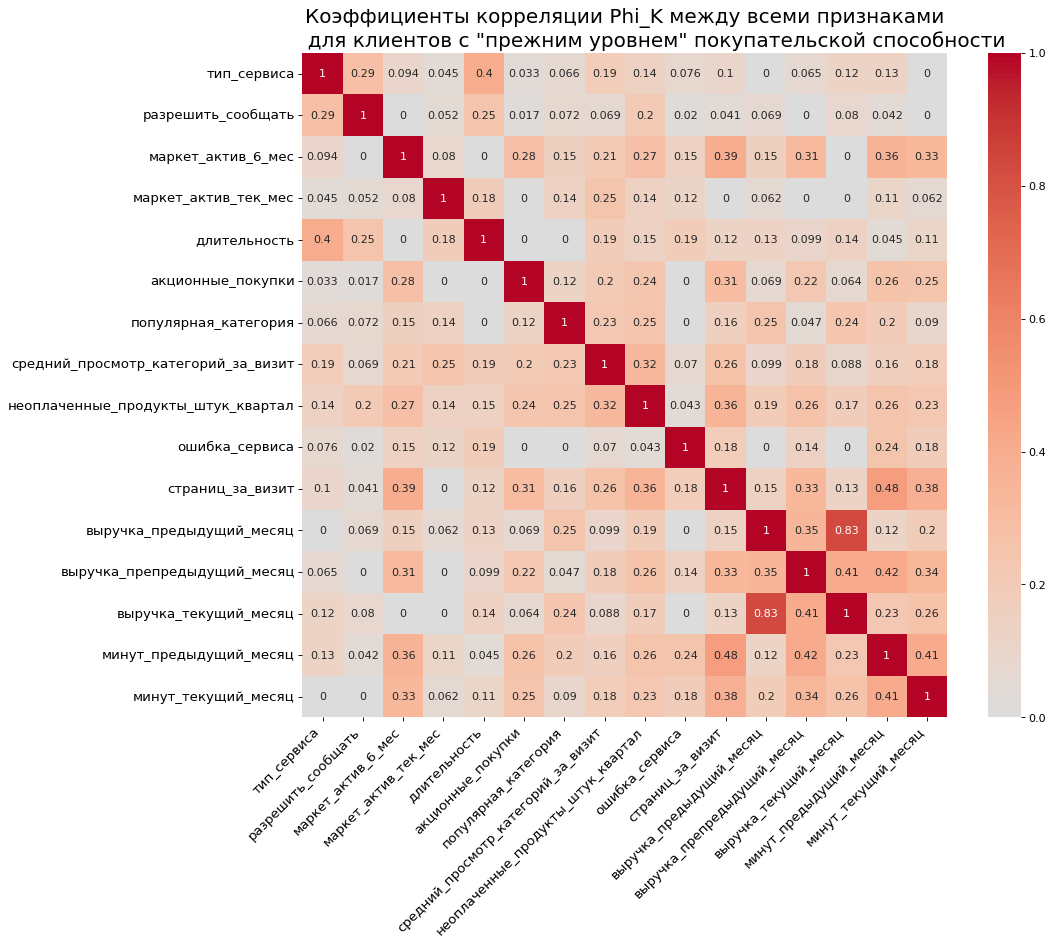

In [ ]:
# plotting the second Phi-K matrix based on the target variable "purchase activity" = previous level

mf = market_file.query('покупательская_активность == "прежний_уровень"')
mf = market_file.drop(['id','покупательская_активность'], axis=1)

phik_matrix = mf.phik_matrix(interval_cols=['маркет_актив_6_мес',
                     'маркет_актив_тек_мес',
                     'длительность',
                     'акционные_покупки',
                     'средний_просмотр_категорий_за_визит',
                     'неоплаченные_продукты_штук_квартал',
                     'ошибка_сервиса',
                     'страниц_за_визит',
                     'выручка_предыдущий_месяц',
                     'выручка_препредыдущий_месяц',
                     'выручка_текущий_месяц',
                     'минут_предыдущий_месяц',
                     'минут_текущий_месяц'])

# the matrix is quite large, so it's better to view it as a heatmap
plt.figure(figsize=(13,11), dpi= 80)
sns.heatmap(phik_matrix.values, xticklabels=phik_matrix.columns, yticklabels=phik_matrix.index, cmap='coolwarm', center=0, annot=True)

plt.title('Phi-K correlation coefficients between all features\n for clients with "previous level" of purchasing power' , fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

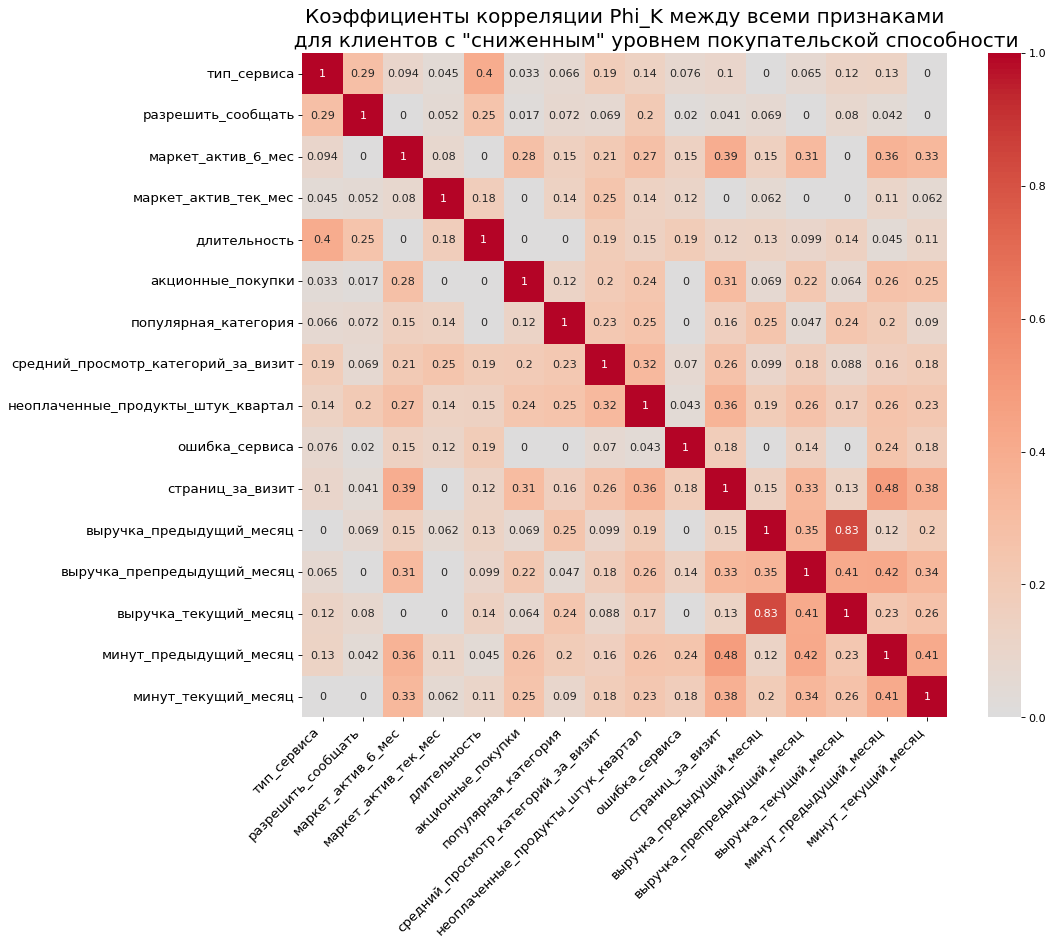

In [ ]:
# plotting the third Phi-K matrix based on the target variable "purchase activity" = decreased

mf1 = market_file.query('покупательская_активность == "снизилась"')
mf1 = market_file.drop(['id','покупательская_активность'], axis=1)

phik_matrix = mf1.phik_matrix(interval_cols=['маркет_актив_6_мес',
                     'маркет_актив_тек_мес',
                     'длительность',
                     'акционные_покупки',
                     'средний_просмотр_категорий_за_визит',
                     'неоплаченные_продукты_штук_квартал',
                     'ошибка_сервиса',
                     'страниц_за_визит',
                     'выручка_предыдущий_месяц',
                     'выручка_препредыдущий_месяц',
                     'выручка_текущий_месяц',
                     'минут_предыдущий_месяц',
                     'минут_текущий_месяц'])

# the matrix is quite large, so it's better to view it as a heatmap
plt.figure(figsize=(13,11), dpi= 80)
sns.heatmap(phik_matrix.values, 
            xticklabels=phik_matrix.columns, 
            yticklabels=phik_matrix.index, 
            cmap='coolwarm', center=0, annot=True)

plt.title('Phi-K correlation coefficients between all features for clients with "reduced" purchasing power' , fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

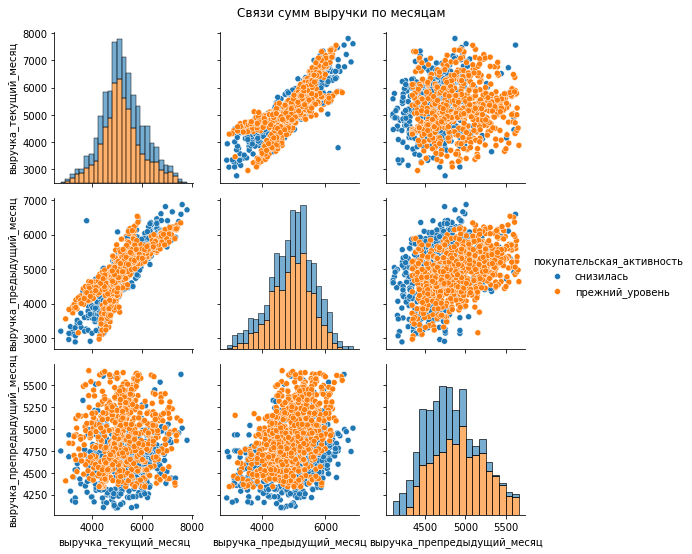

In [ ]:
# take a closer look at the potential relationships between the revenue features by month

revenue = market_file[['выручка_текущий_месяц','выручка_предыдущий_месяц',
                       'выручка_препредыдущий_месяц','покупательская_активность']]

g = sns.PairGrid(revenue, hue="покупательская_активность")
g.map_diag(sns.histplot,multiple="stack",alpha=0.6)
g.map_offdiag(sns.scatterplot)
g.fig.suptitle("Relationships of revenue sums by month", y=1.02) 
g.add_legend();


There is a clear dependence between the revenue sums of the previous month and the current month, and it appears that there are two possible relationships (the graph shows two directions). Let's check the correlation of the current month with the sum of the two previous months:

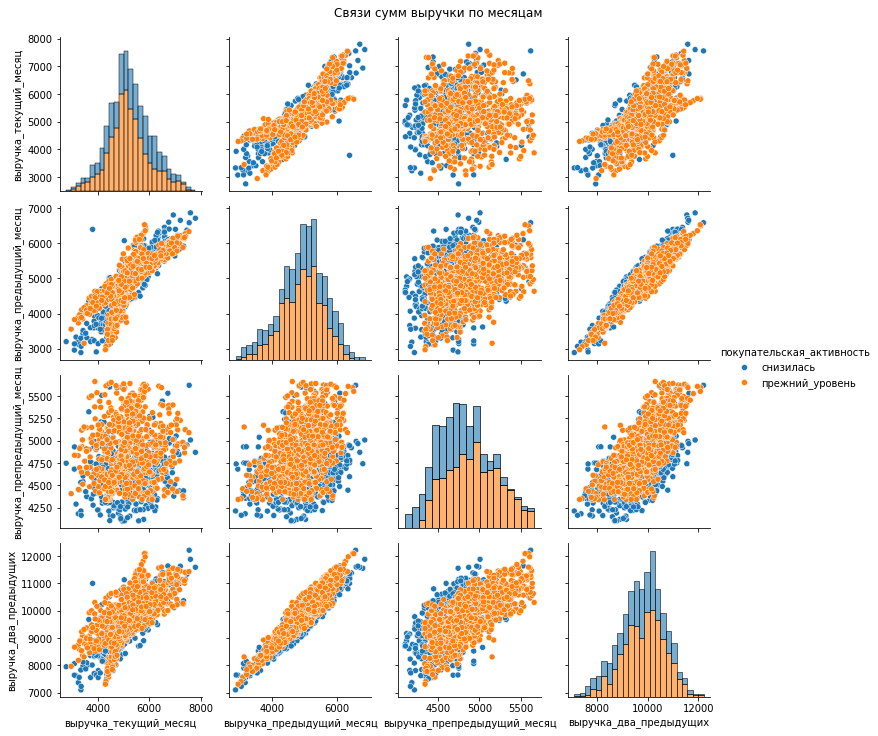

In [ ]:
revenue.loc[:,'выручка_два_предыдущих'] = revenue['выручка_предыдущий_месяц'] + \
                                        revenue['выручка_препредыдущий_месяц']

# take a look at the graph of relationships with the new column of data
g = sns.PairGrid(revenue, hue="покупательская_активность")
g.map_diag(sns.histplot,multiple="stack",alpha=0.6)
g.map_offdiag(sns.scatterplot)
g.fig.suptitle("Relationships of revenue sums by month", y=1.02) 
g.add_legend();

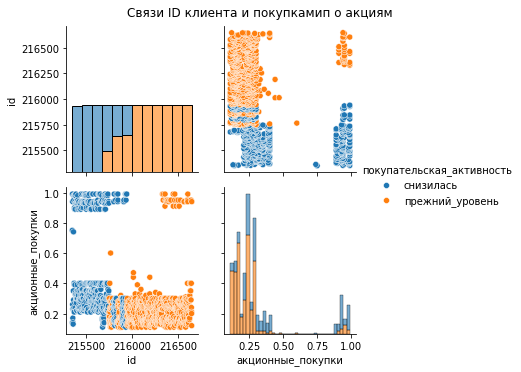

In [ ]:
# examine the potential relationship between id and promotional purchases

id_akcii = market_file[['id','акционные_покупки','покупательская_активность']]

# take a look at the graph of relationships with the new column of data
g = sns.PairGrid(id_akcii, hue="покупательская_активность")
g.map_diag(sns.histplot,multiple="stack",alpha=0.6)
g.map_offdiag(sns.scatterplot)
g.fig.suptitle("Relationships between customer ID and promotional purchases", y=1.02) 
g.add_legend();

**Conclusion**

In the correlation table between quantitative features, we observe predominantly very weak correlations (the Spearman correlation coefficient rarely exceeds 0.3). The only strong connection identified is between the revenues of the previous month and the current month, with a coefficient of 0.88; however, the recommended threshold for multicollinearity (0.9-0.95) is not reached, and it is suggested not to exclude either feature. The VIF method also indicated a relationship between these features, but it is not critical for declaring multicollinearity.

The Phi_K correlation check revealed connections of the target feature "purchasing activity" with most features (especially with the number of pages viewed and minutes spent on the site, which is logical), while the weakest correlation was found with the permission to inform about marketing promotions, and marketing communications in the current month (coefficient = 0), and the duration since user registration (coefficient = 0.1). However, when constructing correlation tables using the Phi_K method, no differences in correlation coefficients were found when divided by the target feature "purchasing activity."

Additionally, the relationships between revenue sums for different months were examined, and it was determined that the revenue of the current month is highly correlated with the revenue sums of the previous two months. This consistent revenue from month to month may be due to groups of customers with mandatory payments (e.g., subscriptions for premium services), seasonality, or groups of customers with regular purchases/contracts.

The examination of the relationship between ID numbers and the sums of promotional purchases showed the existence of two groups of users: those with older IDs tend to buy more promotional goods than those with newer IDs. This may be related to marketing campaigns that offer more attractive conditions for older clients.

<a id='Обучение-моделей-с-применением-пайплайнов'></a>
## Training models using pipelines
[Table of Contents](#Table-of-Contents)

Let’s prepare a unified pipeline to test all specified models with hyperparameter tuning, using ROC-AUC as the evaluation metric, as it is a versatile metric for binary classification tasks, particularly when the classes are imbalanced and independent of the classification threshold.

In [ ]:
%%time

# set constants
RANDOM_STATE = 42
TEST_SIZE = 0.25

# save original indexes
original_indices = np.arange(len(market_file))

# split data into train and test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    market_file.drop(['id','покупательская_активность'], axis=1),
    market_file['покупательская_активность'],
    original_indices,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_file['покупательская_активность'])

# code target feature with LabelEncoder
label_mapping = {'снизилась': 1, 'прежний_уровень': 0}
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.map(label_mapping)) 
y_test = label_encoder.transform(y_test.map(label_mapping)) 


# take a look on ratio of data sets for training and tests
display(X_train.shape, X_test.shape)

# make lists of columns for different types of features
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес']
num_columns = ['ошибка_сервиса','неоплаченные_продукты_штук_квартал','средний_просмотр_категорий_за_визит',
               'страниц_за_визит','выручка_предыдущий_месяц','выручка_препредыдущий_месяц','выручка_текущий_месяц',
               'минут_предыдущий_месяц','минут_текущий_месяц']

# creating a pipeline for feature preparation from ohe_columns list: filling missing values and OHE encoding
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# creating a pipeline for feature preparation from ord_columns list: filling missing values and Ordinal encoding
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    [3, 4, 5], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


# creating a general pipeline for data preparation
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

# calculate number of features after data preprocessing
max_features = data_preprocessor.fit_transform(X_train).shape[1]
display(max_features)

# creating final pipeline: data preparation and model
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # dictionary for DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,20),
        'models__max_features': range(2,max_features+1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # dictionary for KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # dictionary for LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # dictionary for SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel': ['rbf','sigmoid','poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# exhaustive hyperparameter search using GridSearchCV
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,

)
grid_search.fit(X_train, y_train)


(972, 16)

(325, 16)

20

CPU times: user 3min 11s, sys: 423 ms, total: 3min 11s
Wall time: 3min 12s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать',...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__kernel': ['rbf', 'sigmoid', 'poly'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [ ]:
print('Best model and its parameters:\n\n', grid_search.best_estimator_)
print ('Best models metric with cross-validation:', grid_search.best_score_)

# check model performance on test set
# calculate predictions on test data
y_test_pred = grid_search.predict_proba(X_test)[:,1]
print(f'Metric ROC-AUC on the test set: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                  

**Conclusion**  

As a result of applying a unified pipeline for training four types of models - KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC() - the logistic regression model was selected with regularization parameter C=1 based on 14 features, showing ROC-AUC metric of 90% on the training set and over 92% on the test set respectively, which is quite a high result.

<a id='Feature-importance-analysis'></a>
## Feature importance analysis
[Back to contents](#Contents)

We will build coefficient graphs and a Shapley value diagram for feature importance analysis:

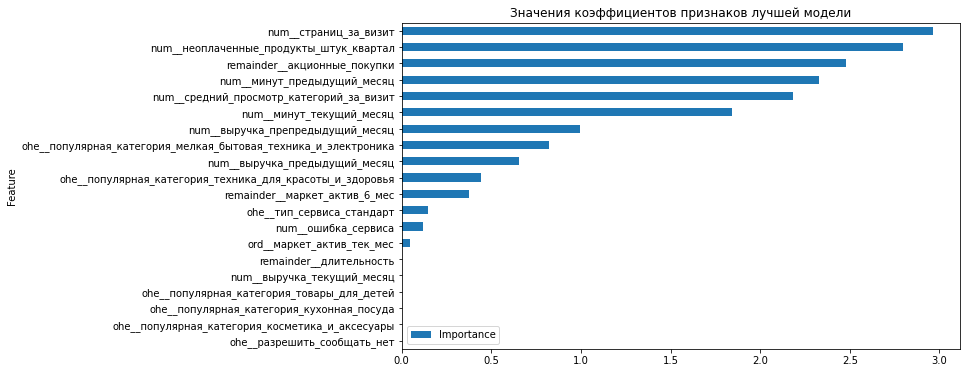

In [ ]:
# take best model
best_model = grid_search.best_estimator_

# take all steps from pipeline
preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['models']

# take names of features after transformations
preprocessed_feature_names = preprocessor.get_feature_names_out()

# take coefficients from model
coefficients = model.coef_[0]

# plot graph of feature importance
feature_importance = pd.DataFrame({'Feature': preprocessed_feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', 
                        kind='barh', figsize=(10, 6), 
                        title='Coefficients of the best models features');


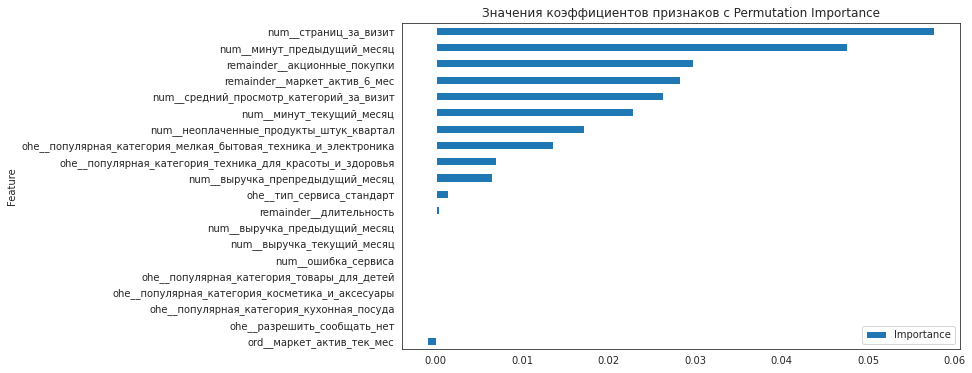

In [ ]:
# check also coefficients of features with Permutation Importance
# for this, we need to load the prepared data and wrap it in a dataframe - this will also be useful for the values of Shapley
X_train_preprocessed = data_preprocessor.transform(X_train)
X_test_preprocessed = data_preprocessor.transform(X_test)

# make a dataframe
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=preprocessed_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessed_feature_names)


def custom_ROC(model, X, y):
    y_pred = model.predict(X)
    score = roc_auc_score(y, y_pred)
    return score

result = permutation_importance(model, X_test_preprocessed, y_test, scoring=custom_ROC)

feature_importance = pd.DataFrame({'Feature': preprocessed_feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', 
                        figsize=(10, 6),title='Coefficients of the features with Permutation Importance');
 

In [ ]:
# also for logistic regression model, let's look at how the odds of being assigned to a class change
# with a change in the feature

# applyy the exponential to the coefficients
odds_ratios = np.exp(coefficients)

# print the odds ratios
print("Probabilities of belonging to a class when changing one feature by one unit:\n")
for i, coef in enumerate(coefficients):
    print(f'{preprocessed_feature_names[i]}: {odds_ratios[i]}')

Шансы отнесения к классу при изменении признака на одну единицу:

ohe__тип_сервиса_стандарт: 1.1561347595263283
ohe__разрешить_сообщать_нет: 1.0
ohe__популярная_категория_косметика_и_аксесуары: 1.0
ohe__популярная_категория_кухонная_посуда: 1.0
ohe__популярная_категория_мелкая_бытовая_техника_и_электроника: 0.4399797729783087
ohe__популярная_категория_техника_для_красоты_и_здоровья: 0.6419603946389241
ohe__популярная_категория_товары_для_детей: 1.0
ord__маркет_актив_тек_мес: 1.0502846764705298
num__ошибка_сервиса: 0.887936271995539
num__неоплаченные_продукты_штук_квартал: 16.39162023031231
num__средний_просмотр_категорий_за_визит: 0.1125822457968816
num__страниц_за_визит: 0.05160959222591631
num__выручка_предыдущий_месяц: 1.920098478789086
num__выручка_препредыдущий_месяц: 0.36933115377817105
num__выручка_текущий_месяц: 1.0
num__минут_предыдущий_месяц: 0.09772393300652886
num__минут_текущий_месяц: 0.15806618921531226
remainder__маркет_актив_6_мес: 0.6880879263425522
remainder__длительн

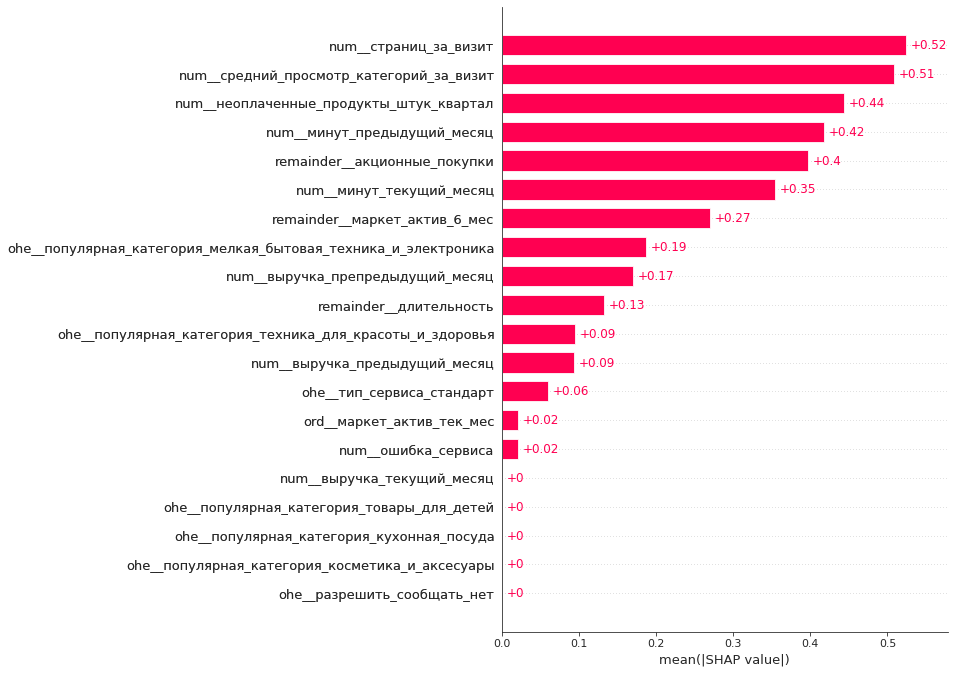

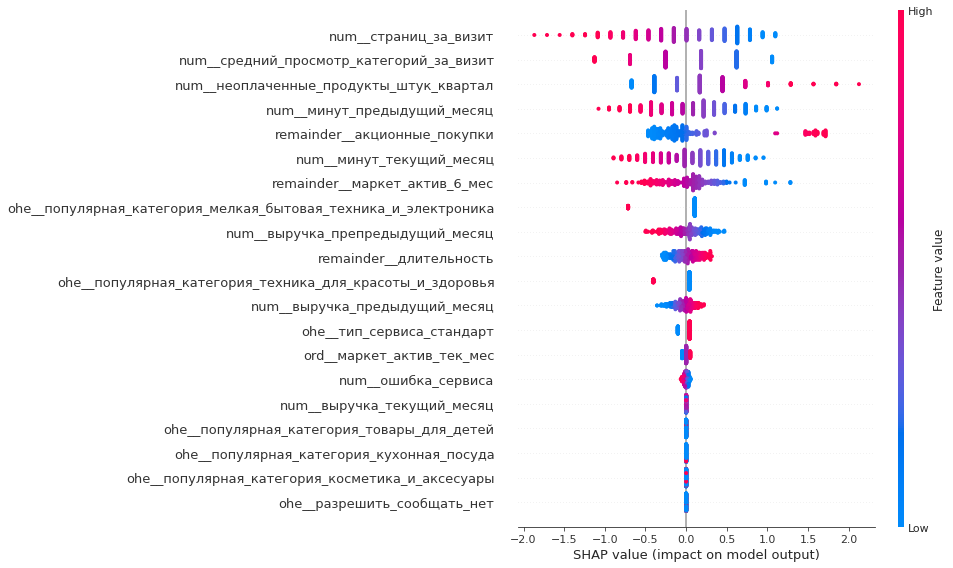

In [ ]:
# build a plot and a diagram of the values of the Shapley
explainer = shap.LinearExplainer(model, X_train_preprocessed_df)
shap_values = explainer(X_test_preprocessed_df)

shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20) 
plt.show()

**Conclusion**

Based on the **coefficients distribution graph**, it is clear that the top 6 features contributing to the assessment in the best model are:

* страниц_за_визит (pages per visit)
* неоплаченные_продукты_штук_квартал (unpaid products per quarter)
* акционные покупки (discounted purchases)
* минут_предыдущий месяц (minutes in previous month)
* средний_просмотр_категорий_за_визит (average category views per visit)
* минут_текущий месяц (minutes in current month)

The influence of the next 8 features is significantly less, and the model has completely nullified the coefficients for the following features, considering their impact negligible:

* длительность (duration)
* популярная_категория_Товары_для_детей (popular category - Toys for Children)
* выручка_текущий месяц (current month revenue)
* популярная_категория_Кухонная_посуда (popular category - Kitchenware)
* популярная_категория_Косметика_и_аксесуары (popular category - Cosmetics and Accessories)
* разрешить_сообщать_нет (allow notifications)
These features are mostly categorical and ordinal, and do not characterize the customer in terms of activity. Notably, the model has excluded current revenue as a feature.

**Permutation Importance** revealed the same favorites with slight changes in importance order (pages per visit, discounted purchases, minutes in previous month, minutes in current month, маркет_актив_6_мес, average category views per visit).

Additionally, we looked at how changing each feature by one unit affects the chances of belonging to a class - the largest impact is made by unpaid products and discounted purchases.

**Shapley values** also show that the most influential features are the same, but the distribution of each feature's contribution differs. The main features correspond to:

* страниц_за_визит (pages per visit)
* средний_просмотр_категорий_за_визит (average category views per visit)
* неоплаченные_продукты_штук_квартал (unpaid products per quarter)
* минут_предыдущий месяц (minutes in previous month)
* акционные_покупки (discounted purchases)
* минут_текущий месяц (minutes in current month)

Also, according to this method, the features with zero contribution to assessment are exactly the same (excluding duration):

* выручка_текущий месяц (current month revenue)
* популярная_категория_Товары_для_детей (popular category - Toys for Children)
* популярная_категория_Кухонная_посуда (popular category - Kitchenware)
* популярная_категория_Косметика_и_аксесуары (popular category - Cosmetics and Accessories)
* разрешить_сообщать_нет (allow notifications).

Taking into account the importance of features, we can make conclusions that the feature of preferred product category has a minimal impact on the assessment of customer activity, as well as technical features such as errors in service operation and data on current revenue. These features are either not worth considering in future models (with regular verification), or it is necessary to focus on retaining customers on the site by increasing page views and time spent on the site (expanding the assortment = showing similar products, more time for selection and possibility of finding a suitable product).


<a id='customer-segmentation'></a>
## Customer Segmentation
[Back to Contents](#To-contents)

We will apply the trained model to our own dataset, obtain probabilities of belonging to classes 0 (customer activity remains unchanged) and 1 (customer activity decreases), and form predictions. We will also explore options for user segmentation simultaneously.

In [ ]:
# threshold of classification leave the standard
threshold = 0.5

# reset the order of records in accordance with the original array of data market_file
X_train_pr_restored = X_train_preprocessed[np.argsort(indices_train)]
X_test_pr_restored = X_test_preprocessed[np.argsort(indices_test)]
X_full = np.vstack((X_train_pr_restored, X_test_pr_restored))

# apply the model to all data
predictions = model.predict_proba(X_full)[:, 1]
predictions_class = np.where(predictions > threshold, True, False)

# add the probabilities and features, as well as data on the profit to the original data array
market_file = market_file.assign(вероятность=predictions, признак_снижения=predictions_class)
market_file = market_file.merge(money, on='id', how='outer')

#check the dimensions and NaN after the unions
display(market_file.shape)
display(market_file.isna().sum().sum())

# take only those data for which the model predicted a decline
market_file_decline = market_file.loc[market_file['признак_снижения'] == True]

market_file_decline.head(10)


(1297, 21)

0

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,вероятность,признак_снижения,прибыль
1,215350,снизилась,стандарт,нет,4.900,3,539,0.140,домашний_текстиль,5,...,1,5,5457.500,4826.000,5058.400,8,13,0.958,True,3.130
3,215352,снизилась,стандарт,нет,5.100,3,1064,0.940,товары_для_детей,3,...,3,2,5807.500,4594.000,5872.500,8,11,0.566,True,4.210
4,215353,снизилась,стандарт,да,3.300,4,762,0.260,домашний_текстиль,4,...,1,4,4738.500,5124.000,5388.500,10,10,0.546,True,3.950
6,215355,снизилась,стандарт,нет,4.700,4,284,0.170,товары_для_детей,5,...,6,4,3263.000,4749.000,3772.600,12,10,0.719,True,5.260
7,215356,снизилась,стандарт,да,4.200,4,192,0.140,косметика_и_аксесуары,2,...,1,3,4146.500,4433.000,4566.400,6,7,0.837,True,4.930
8,215358,снизилась,стандарт,да,4.700,4,450,0.130,домашний_текстиль,4,...,6,4,3488.000,4727.000,4209.500,14,10,0.846,True,3.060
9,215360,снизилась,премиум,да,3.900,3,623,0.350,кухонная_посуда,3,...,4,7,5304.500,5555.000,5834.900,9,6,0.820,True,4.550
11,215362,снизилась,премиум,да,4.200,4,438,0.740,домашний_текстиль,3,...,6,4,4314.000,4765.000,4447.900,13,13,0.987,True,3.490
12,215363,снизилась,стандарт,нет,4.900,4,923,0.290,товары_для_детей,6,...,3,1,6010.000,4633.000,6128.300,8,5,0.921,True,1.830
13,215364,снизилась,премиум,да,4.300,4,708,0.980,домашний_текстиль,3,...,3,3,5795.500,4942.000,5484.800,11,9,0.937,True,2.670


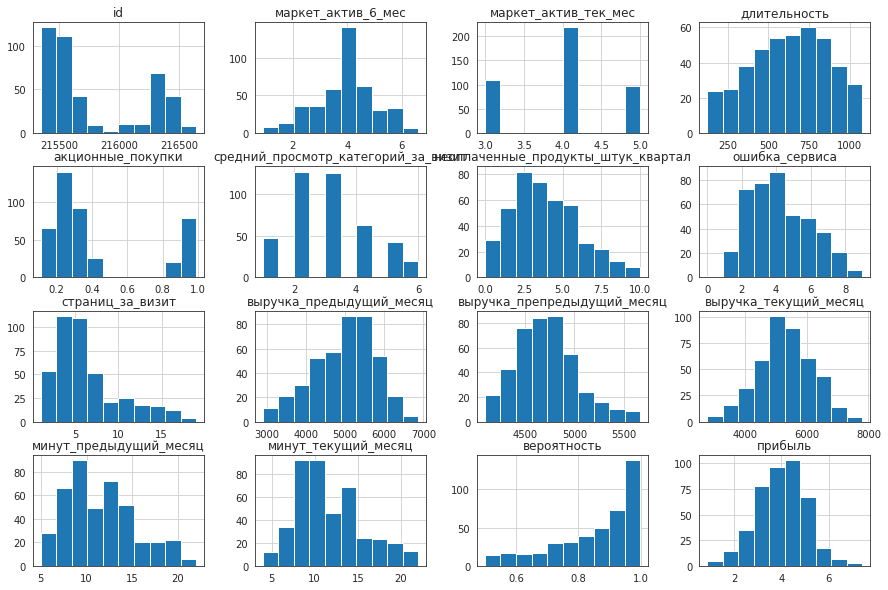

In [ ]:
# take a look at the distribution of quantitative features in the dataset obtained for segmentation
market_file_decline.hist(figsize=(15, 10))
plt.show();

**Segmentation Options**

- Segments by categories of sales goods
- By behavior within promotional offers (clear separation is evident)
- Or by types of popular product categories

However, I decided to divide users prone to a decrease in customer activity based on the most sensitive feature - profit, and consider a segment of the most profitable clients who are likely to reduce their activity in the near future.

In [ ]:
# see metrics on profit
market_file_decline['прибыль'].describe()

count   425.000
mean      4.009
std       1.057
min       0.860
25%       3.260
50%       4.040
75%       4.690
max       7.430
Name: прибыль, dtype: float64

In [ ]:
# distribution on quartiles will help to identify the segment with the highest profit level - with a profit level above 4.69
# count the number of such customers
print(f'Quantity of cstomers with highest profit:{market_file_decline[market_file_decline["прибыль"]>=4.690]["id"].count()}')

# and for comparison, we will get similar data for the segment of the rest
print(f'Quantity other "problem" customers:{market_file_decline[market_file_decline["прибыль"]<4.690]["id"].count()}')


Количество покупаталей с наибольшим доходом:108
Количество прочих "проблемных" покупаталей:317


In [ ]:
# calculate the share of these 108 most profitable customers in the revenue of "problematic" (which may reduce activity)
print(f'Ratio of the most profitable customers in set of "problem" customers: '
      f'{market_file_decline[market_file_decline["прибыль"]>= 4.690]["прибыль"].sum()/market_file_decline["прибыль"].sum() * 100}')

# count the share of these 108 most profitable customers and the rest of the less profitable
# in revenue of all customers (including those with normal purchasing activity)
print(f'The proportion of the most profitable customers compared to the overall profit generated by all clients: '
      f'{market_file_decline[market_file_decline["прибыль"]>=4.690]["прибыль"].sum() / market_file["прибыль"].sum() * 100}')

print(f'The proportion of the remaining customers compared to the overall profit generated by all clients: '
      f'{market_file_decline[market_file_decline["прибыль"]<4.690]["прибыль"].sum() / market_file["прибыль"].sum() * 100}')

Доля наиболее прибыльных в выборке "проблемных" клиентов: 33.58863890171051
Доля наиболее прибыльных "проблемных" клиентов в прибыли от всех клиентов: 11.03762686252594
Доля остальных "проблемных" клиентов в прибыли от всех клиентов: 21.823565661907196


In [ ]:
# take theese 108 customers in separate dataframe for convenience of analysis
decline_max_profit_customers = market_file_decline.loc[market_file_decline['прибыль'] >= 4.69]

# and all the rest of the problem customers
decline_min_profit_customers = market_file_decline.loc[market_file_decline['прибыль'] < 4.69]


In [ ]:
# take a lookk at the ratio of customers of different types of service to two segments
print(f'Distribution by service type of most profitable problematic customers:\n'
      f'{decline_max_profit_customers["тип_сервиса"].value_counts()} \n')

print(f'Distribution by service type of remaining problematic customers:\n'
      f'{decline_min_profit_customers["тип_сервиса"].value_counts()}')

Распределение по типам сервиса наиболее прибыльных "проблемных" клиентов:
тип_сервиса
стандарт    71
премиум     37
Name: count, dtype: int64 

Распределение по типам сервиса остальных "проблемных" клиентов:
тип_сервиса
стандарт    207
премиум     110
Name: count, dtype: int64


Объемы маркетингового взимодействия с наиболее прибыльными "проблемными" клиентами:


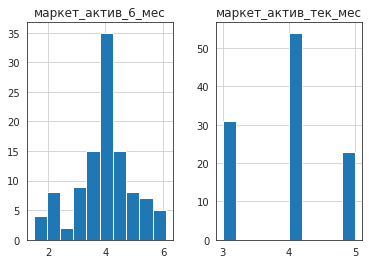

Объемы маркетингового взимодействия с остальными "проблемными" клиентами:


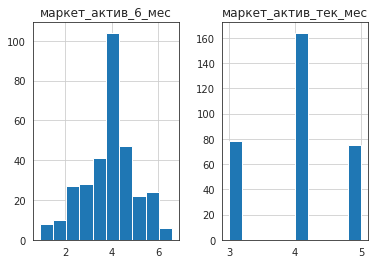

In [ ]:
# take a look at marketing interactions with these customers
print('Marketing interaction volumes with most profitable problematic customers:')
decline_max_profit_customers[['маркет_актив_6_мес','маркет_актив_тек_мес']].hist()
plt.show()

print('Marketing interaction volumes with other problematic customers:')
decline_min_profit_customers[['маркет_актив_6_мес','маркет_актив_тек_мес']].hist()
plt.show();

Объемы акционных покупок наиболее прибыльных "проблемных" клиентов:


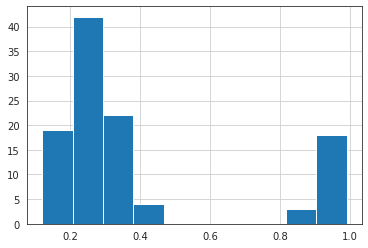

Объемы акционных покупок остальных "проблемных" клиентов:


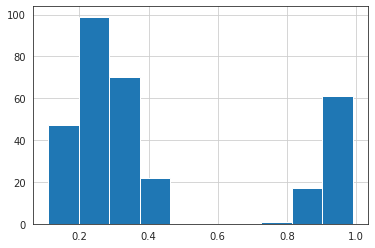

In [ ]:
# check if the split of the promotional purchases we observed on more general data is observed
print('Volumes of discounted purchases by most profitable problematic customers:')
decline_max_profit_customers['акционные_покупки'].hist();
plt.show()

print('Volumes of discounted purchases by other problematic customers:')
decline_min_profit_customers['акционные_покупки'].hist()
plt.show();

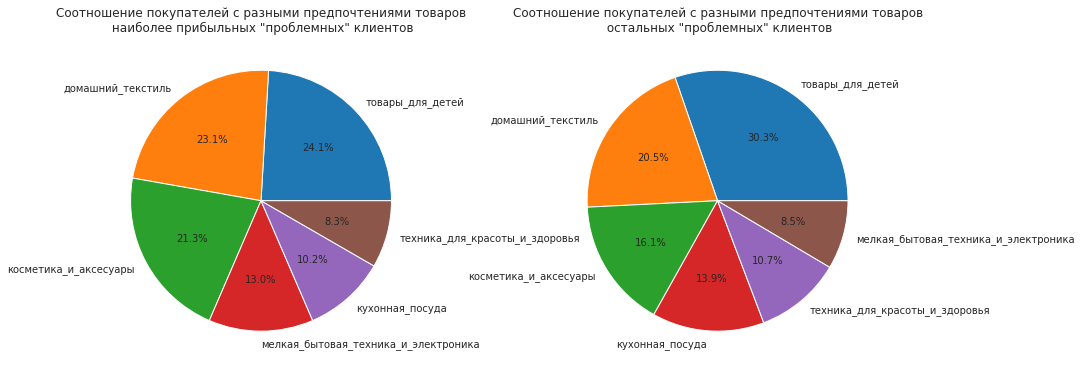

In [ ]:
# and check if there is a tendency to any category of goods among these customers
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
decline_max_profit_customers['популярная_категория'].value_counts().plot(kind='pie', 
             title ='Ratio of customers with different product preferences\n among most profitable problematic customers',
             radius=1,
             ylabel='',
             autopct= '%1.1f%%')

plt.subplot(1, 2, 2)
decline_min_profit_customers['популярная_категория'].value_counts().plot(kind='pie', 
             title ='Ratio of customers with different product preferences\n among other problematic customers',
             radius=1,
             ylabel='',
             autopct= '%1.1f%%');


In [ ]:
# check problems of customers of this segment with the service by the average number of failures
print(f'Average number of errors for most profitable problematic customers: '
      f'{decline_max_profit_customers["ошибка_сервиса"].mean()}\n')

print(f'Average number of errors for other problematic customers: '
      f'{decline_min_profit_customers["ошибка_сервиса"].mean()}\n')

# and for comparison, the average value for all users
print(f'Average number of errors for all customers: '
      f'{market_file["ошибка_сервиса"].mean()}\n')


Среднее количество сбоев для наиболее прибыльных "проблемных" покупателей: 4.324074074074074

Среднее количество сбоев для остальных "проблемных" покупателей: 4.141955835962145

Среднее количество сбоев для всех покупателей: 4.184271395528142



**Conclusion**

Upon analyzing the segment of 25% most profitable customers from the dataset of "problematic" clients, including a comparison with the second segment of all other customers prone to reducing their purchasing capacity (hereinafter referred to as problematic clients), we observed that these 108 individuals (out of 1297 observed in the dataset) account for 33% of the profit of problematic clients and 11% of the total profit of all clients. The remaining problematic clients comprise 67% and 22%, respectively.

From a retention perspective, it would be interesting to consider this segment of most profitable problematic customers with respect to additional opportunities/recommendations beyond the characteristics identified by the model as having the greatest impact on changing purchasing behavior for the entire dataset in the previous section.

Thus:

* we noticed that 2/3 of the customers in this segment are using a standard type of service, which suggests that it would be possible to recommend upgrading their service class to either random or most profitable clients;
* marketing communication levels correspond to the overall client selection and do not exceed parameters; therefore, there is an opportunity to strengthen communications with the aim of stimulating purchases among these customers;
* further work on/ targeting promotional policy could increase the level of discounted product purchases (there is a significant subsample of customers who are poorly buying discounted products);
* no patterns in terms of popular categories of goods were identified for this segment;
* the average number of service errors for the considered clients corresponds to the overall selection - in this case, recommendations of a general nature about reducing values of this characteristic are applicable.

In comparison with other problematic customers, no significant differences were observed regarding the specified parameters; the only exception is that the average number of technical service errors among most profitable problematic customers is slightly higher (4.32) compared to the remaining problematic clients (4.14) and the overall selection of all clients (4.18).

Given the main difference between segments lies in profitability, it may be worth checking other hypotheses for segmenting - to find asymmetric features affecting classification of customers and identify additional opportunities to influence retention of problematic clients.

 <a id='#General-conclusion'></a>
## General conclusion
[Back to Contets](#To-contents)

Within the scope of this project, **it was necessary to** categorize customers by two levels of purchasing activity - "unchanged" and "decreased". This required training multiple types of machine learning models and selecting the best one, followed by segmenting the data and considering possible recommendations for retaining clients in a specific segment.

Upon loading the data, it immediately became apparent that **some corrections were needed** to remove inaccuracies. Therefore, during the **data preprocessing stage**, the following adjustments were made:

* Corrections were made to column names;
* Spaces in text data tables were replaced with underscores, and implicit duplicates and typos were identified and corrected. Text data was converted to lowercase;
* Numerical data was converted to int32 and float32 types as necessary.

**Exploratory Data Analysis** revealed one anomaly related to revenue for one of the customers - this value was replaced with the mean value. Additionally, some quantitative features were distributed closely to normal, but not all. This was taken into account during further correlation analysis, which is described in more detail below:

* In the table containing user and purchase data (market_file), it can be seen that numerical data are not distributed normally for all variables. Consequently, this must be considered when evaluating correlations. Anomalies were not detected in these data, but there were outliers within acceptable limits. Binary categorical features are also distributed unevenly - perhaps it would be beneficial to apply class balancing techniques. Data on the multiclass feature "popular categories" are more evenly distributed.
* In the table containing revenue for the last 3 months (market_money), one anomaly with an extremely large purchase amount was replaced with the mean value for the entire table. Additionally, data for three users who did not make purchases in the previous months were removed from all tables. The corrected revenue data (both overall and per month) are distributed closely to normal, and outliers are negligible.
* In the table containing time spent on the website (market_time), no anomalies or outliers were detected. Data distribution is close to normal for both 2-month and current periods, while the previous period shows a mean value with two approximately equal peaks at slightly less than and slightly more than the average.
* In the table containing average monthly profit for the last 3 months (money), no anomalies or critical outliers were detected. The data are distributed closely to normal.

Subsequently, tables (excluding client profitability data) **were merged** into a single dataframe for ease of correlation analysis and preparing data for model training. Revenue and time spent on the website data were distributed and included in the general table per month for each user.

**Correlation Analysis** between quantitative features revealed minor relationships (rarely is the Pearson correlation coefficient greater than 0.3). A strong connection was identified between revenue for the previous and current months (0.88), but the recommended threshold for multicollinearity (0.9-0.95) was not reached, and no feature was excluded. The VIF method also showed a connection between these features, but it is non-critical for identifying multicollinearity.

The Phi_K correlation method revealed relationships between the target feature "purchasing activity" and most of the features (particularly with the number of viewed pages and time spent on the website), which is logical. The smallest level of association was observed with marketing announcement resolution, marketing communication in the current month (coefficient = 0), and duration since user registration (coefficient = 0.1).

**Model Selection Pipeline**

A pipeline for training four types of models - KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC() - was created with hyperparameter tuning from 2 to 3 parameters for each model, resulting in the selection of logistic regression with regularization parameter C=1 and 14 features as the best model, achieving a ROC-AUC score of 90% on the training set and over 92% on the test set.

The ROC-AUC metric was chosen for evaluating the models' performance because it is a relatively universal metric for binary classification problems, especially when classes are imbalanced (as noted earlier) and does not depend on the classification threshold.

**Feature Importance Analysis**

The model's coefficients and Shapley value assessment identified the most important features for predicting purchasing ability as:

* pages_per_visit
* average_categories_viewed_per_visit
* uncollected_products_quarterly
* minutes_previous_month
* promotional_purchases
* minutes_current_month

Features with zero contribution to prediction are:

* current_month_revenue
* popular_category_Tools_for_children
* popular_category_Kitchenware
* popular_category_Cosmetics_and_accessories
* allow_marketing_no.

It turns out that the factor of preferred product category has a negligible impact on customer purchasing activity assessment, as well as the technical factor of service errors, data on current month revenue and flag for receiving marketing materials. These factors, first, do not make sense to consider in future models (provided regular checks without any conditions, since circumstances may change and affect model evaluations), secondly, for increasing customer activity it makes sense to focus on retaining customers on the site - by increasing page views and time spent on the site (expanding the product range = new similar products, more time to choose and ability to find what you need), stimulating purchases through periodic discounts on held goods (no accumulation of uncollected goods - the more there are, the higher the probability of reducing customer behavior).

Before **segmentation**, buyers who were predicted by the model to have a decrease in purchasing activity were selected. Analyzing this part of buyers, the following options for segmentation were proposed:

* Consider users on standard and premium tariffs
* Consider users based on their behavior within promotional offers
* Consider users based on popular product categories

In the end, it was decided to divide users prone to decreasing purchasing activity by the most sensitive factor - profit and consider the segment of the most profitable customers who are likely to decrease their activity in the near future. Analyzing the segment of 25% of the most profitable customers from the sample of "problematic" customers, including a comparison with the second segment of all other customers prone to decreasing purchasing ability (later referred to as "problematic customers"), we see that these 108 people (from 1297 observed in the dataset) form 33% of the profit of problematic customers and 11% of the profit of all customers. Therefore, from the point of view of retention, it would be interesting to consider this segment of most profitable problem customers regarding additional opportunities/recommendations beyond the factors identified by the model as the main influencing factors on changing customer behavior for the entire dataset in the previous section.

Thus:
* noticed that 2/3 of the buyers in the considered segment are on a standard type of service, accordingly, it is possible to recommend giving them the opportunity to upgrade their class of service randomly or to the most profitable customers;
* marketing communication levels correspond to the general sample of customers and do not exceed parameters, in such a case there is an opportunity to enhance communications for stimulating purchases by these customers specifically;
* can additionally work out/targeted promotional policy to increase the level of purchasing promotional products (there is a significant sub-segment of users who poorly buy promotional products);
* no preferences were detected among the considered segment of buyers regarding popular product categories;
* the average number of service errors for the considered clients corresponds to the general sample - in this case, recommendations of a general nature are made about reducing values of this indicator.

In comparison with other problem customers, differences on the specified parameters are practically not detected, only the average number of technical service errors is slightly higher (4.32) among the most profitable problem customers compared to other problems (4.14) and overall in the sample of all customers (4.18).

Given that the main difference between segments is only by profitability, it may make sense to check other segmentation hypotheses - for searching asymmetry in factors affecting customer classification, to find additional opportunities to influence retention of problematic customers.